In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [366]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread
import math
import pandas as pd

In [ ]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

# simple test model

In [19]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

In [4]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.out = nn.Linear(1024, 10)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [7]:
net = NN()

In [8]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.poutine as poutine

In [9]:
def dense_normal_prior(name, params):
    mu_param = pyro.param('{}_mu'.format(name), torch.zeros_like(params))
    sigma_param = F.softplus(pyro.param("{}_sigma".format(name), torch.ones_like(params)))
    prior = Normal(loc=mu_param, scale=sigma_param)
    return prior

In [10]:
log_softmax = nn.LogSoftmax(dim=1)

In [11]:
def model(x_data, y_data):
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))

    priors = {
        'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,
        'out.weight': outw_prior, 'out.bias': outb_prior
    }

    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)

    # sample a classifier
    lifted_reg_model = lifted_module()

    p_hat = log_softmax(lifted_reg_model(x_data))

    pyro.sample("obs", Categorical(logits=p_hat), obs=y_data)

In [12]:
def guide(x_data, y_data):
    # fc1 weight distribution priors
    fc1w_prior = dense_normal_prior('fc1w', net.fc1.weight)
    # fc1 bias distribution priors
    fc1b_prior = dense_normal_prior('fc1b', net.fc1.bias)

    # fc3 weight distribution priors
    outw_prior = dense_normal_prior('outw', net.out.weight)
    # fc3 bias distribution priors
    outb_prior = dense_normal_prior('outb', net.out.bias)

    priors = {
        'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,
        'out.weight': outw_prior, 'out.bias': outb_prior
    }

    lifted_module = pyro.random_module("module", net, priors)
    return lifted_module()

In [13]:
net.cuda()

NN(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)

In [14]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [82]:
def predict(x, T):
    sampled_models = [guide(None, None) for _ in range(T)]
    yhats = [model(x).data for model in sampled_models]
    yhats = torch.stack(yhats, dim=1)
    mean = torch.mean(yhats, 1)
    return np.argmax(mean.cpu().numpy(), axis=1)

def evaluate(T, loader):
    correct = 0
    total = 0
    for j, data in enumerate(loader):
        images, labels = data
        predicted = predict(images.view(images.size(0), -1).cuda(), T=T)
        total += labels.size(0)
        correct += (predicted == np.array(labels)).sum().item()
    return (100 * correct / total)

In [21]:
num_iterations = 10
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(data[0].size(0), -1).cuda(), data[1].cuda())
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    acc = evaluate(10, test_loader)
    print("Epoch ", j, " Loss ", total_epoch_loss_train, 'Accuracy ', acc)

Epoch  0  Loss  84.36735980621974 Accuracy  89.03
Epoch  1  Loss  84.09832319690386 Accuracy  89.72
Epoch  2  Loss  84.27995190889041 Accuracy  89.55
Epoch  3  Loss  84.30779006101291 Accuracy  89.27
Epoch  4  Loss  83.8069900431792 Accuracy  89.02
Epoch  5  Loss  84.53469102640152 Accuracy  89.36
Epoch  6  Loss  83.8996834798336 Accuracy  89.05
Epoch  7  Loss  83.92807042242686 Accuracy  89.59
Epoch  8  Loss  84.11383662295341 Accuracy  89.61
Epoch  9  Loss  84.39601743836403 Accuracy  89.37


## accuracy remove samples with all probability less than 0.5

In [104]:
def predict(x, T):
    sampled_models = [guide(None, None) for _ in range(T)]
    yhats = [model(x).data for model in sampled_models]
    yhats = F.softmax(torch.stack(yhats, dim=1), dim=2)
    mean = torch.mean(yhats, 1)
    return np.argmax(mean.cpu().numpy(), axis=1), mean.cpu().numpy()

def evaluate(T, loader, threshold=0.2):
    correct = 0
    total = 0
    all_cnt = 0
    for j, data in enumerate(loader):
        images, labels = data
        predicted, mean_prob = predict(images.view(images.size(0), -1).cuda(), T=T)
        confidence = np.max(mean_prob, axis=1)
        idx = [idx for idx in range(confidence.shape[0]) if confidence[idx]>threshold]
        all_cnt += len(labels)
        total += len(idx)
        correct += (predicted[idx] == np.array(labels)[idx]).sum().item()
    return (100 * correct / total), all_cnt-total, total/all_cnt

### threshold = 0.5

In [105]:
acc, skip, ratio = evaluate(10, test_loader, threshold=0.5)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)

accuracy is:  93.11460774467136
number of samples skipped : 1039
raio (able to predict/all sample): 0.8961


In [106]:
acc, skip, ratio = evaluate(20, test_loader, threshold=0.5)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)

accuracy is:  93.81741354386745
number of samples skipped : 1007
raio (able to predict/all sample): 0.8993


### threshold = 0.6

In [110]:
acc, skip, ratio = evaluate(10, test_loader, threshold=0.6)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)

accuracy is:  95.27710843373494
number of samples skipped : 1700
raio (able to predict/all sample): 0.83


In [108]:
acc, skip, ratio = evaluate(20, test_loader, threshold=0.6)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)

accuracy is:  96.42380894653897
number of samples skipped : 1751
raio (able to predict/all sample): 0.8249


## Uncertainty Estimation

In [342]:
def predict(x, T):
    sampled_models = [guide(None, None) for _ in range(T)]
    yhats = [model(x).data for model in sampled_models]
    yhats = F.softmax(torch.stack(yhats, dim=1), dim=2)
    mean = torch.mean(yhats, 1).cpu().numpy()
    
    # uncertainty
    # yhats [batch * 10 * 10]
    p_hat = yhats.cpu().numpy()
    aleatoric = np.mean(p_hat*(1-p_hat), axis=1) # batch * 10
    epistemic = np.mean(p_hat**2, axis=1) - np.mean(p_hat, axis=1)**2 # batch * 10
    return np.argmax(mean, axis=1), mean, aleatoric, epistemic

def evaluate(T, loader, threshold=0.2):
    correct = 0
    total = 0
    all_cnt = 0
    total_alea_thresh = 0
    total_epis_thresh = 0
    for j, data in enumerate(loader):
        images, labels = data
        predicted, mean_prob, aleatoric, epistemic = predict(images.view(images.size(0), -1).cuda(), T=T)
        confidence = np.max(mean_prob, axis=1)
        idx = [idx for idx in range(confidence.shape[0]) if confidence[idx]>threshold]
        all_cnt += len(labels)
        total += len(idx)
        correct += (predicted[idx] == np.array(labels)[idx]).sum().item()
        
        # uncertainty for the best choice
        total_alea_thresh += np.choose(predicted, aleatoric.T)[idx].sum().item()
        total_epis_thresh += np.choose(predicted, epistemic.T)[idx].sum().item()
    return (100 * correct / total), all_cnt-total, total/all_cnt, total_alea_thresh/total, total_epis_thresh/total

### threshold 0.5

In [113]:
acc, skip, tatio,mean_alea, mean_epis = evaluate(10, test_loader, threshold=0.5)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)
print('mean epistemic:', mean_epis)
print('mean aleaotoric:', mean_alea)

accuracy is:  93.08652988403212
number of samples skipped : 1032
raio (able to predict/all sample): 0.83
mean epistemic: 0.10166775213885158
mean aleaotoric: 0.002358458893843839


In [114]:
acc, skip, tatio,mean_alea, mean_epis = evaluate(20, test_loader, threshold=0.5)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)
print('mean epistemic:', mean_epis)
print('mean aleaotoric:', mean_alea)

accuracy is:  93.93265918435382
number of samples skipped : 1001
raio (able to predict/all sample): 0.83
mean epistemic: 0.10918405167539062
mean aleaotoric: 0.0023589821815729168


### threshold 0.6

In [120]:
acc, skip, tatio,mean_alea, mean_epis = evaluate(10, test_loader, threshold=0.6)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)
print('mean epistemic:', mean_epis)
print('mean aleaotoric:', mean_alea)

accuracy is:  95.39259437944759
number of samples skipped : 1709
raio (able to predict/all sample): 0.83
mean epistemic: 0.09170494259604355
mean aleaotoric: 0.00199796977906632


In [118]:
acc, skip, tatio,mean_alea, mean_epis = evaluate(20, test_loader, threshold=0.6)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)
print('mean epistemic:', mean_epis)
print('mean aleaotoric:', mean_alea)

accuracy is:  96.4006832601269
number of samples skipped : 1804
raio (able to predict/all sample): 0.83
mean epistemic: 0.09480218217685898
mean aleaotoric: 0.0020654726052623134


In [121]:
acc, skip, tatio,mean_alea, mean_epis = evaluate(30, test_loader, threshold=0.6)
print('accuracy is: ', acc)
print('number of samples skipped :', skip)
print('raio (able to predict/all sample):', ratio)
print('mean epistemic:', mean_epis)
print('mean aleaotoric:', mean_alea)

accuracy is:  96.57275277472863
number of samples skipped : 1801
raio (able to predict/all sample): 0.83
mean epistemic: 0.09811366701405257
mean aleaotoric: 0.0020794412326206268


## analyse the sample with confidence over 0.6 but prediction is wrong

In [156]:
def predict(x, T):
    sampled_models = [guide(None, None) for _ in range(T)]
    yhats = [model(x).data for model in sampled_models]
    yhats = F.softmax(torch.stack(yhats, dim=1), dim=2)
    mean = torch.mean(yhats, 1).cpu().numpy()
    
    # uncertainty
    # yhats [batch * 10 * 10]
    p_hat = yhats.cpu().numpy()
    aleatoric = np.mean(p_hat*(1-p_hat), axis=1) # batch * 10
    epistemic = np.mean(p_hat**2, axis=1) - np.mean(p_hat, axis=1)**2 # batch * 10
    return np.argmax(mean, axis=1), mean, aleatoric, epistemic

def evaluate(T, loader, threshold=0.2):
    for j, data in enumerate(loader):
        images, labels = data
        predicted, mean_prob, aleatoric, epistemic = predict(images.view(images.size(0), -1).cuda(), T=T)
        confidence = np.max(mean_prob, axis=1)
        idx = [idx for idx in range(confidence.shape[0]) if confidence[idx]>threshold]
        correct = (predicted[idx] == np.array(labels)[idx])
        wrong_idx = [i for i in range(len(correct)) if correct[i] == False]
        usable_idx = np.array(idx)[wrong_idx]
        if len(usable_idx)>0:
            return images[usable_idx], labels[usable_idx], mean_prob[usable_idx], aleatoric[usable_idx], epistemic[usable_idx]
        else:
            return 0, 0, 0, 0, 0

In [178]:
image, label, prob, alea, epis = evaluate(30, test_loader, threshold=0.6)

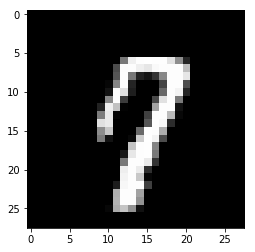

confidence:
[1.3061119e-26 1.9618179e-44 1.1713722e-34 3.3333320e-02 1.5227041e-09
 7.1329935e-11 0.0000000e+00 3.0022436e-01 6.4332724e-02 6.0210967e-01]
label:
7
prediction
9
alea 
[1.3061119e-26 1.9618179e-44 1.1713722e-34 1.5894564e-08 1.5227039e-09
 7.1329935e-11 0.0000000e+00 2.2045302e-03 2.1705243e-03 4.3750312e-03]
epis
[0.0000000e+00 0.0000000e+00 0.0000000e+00 3.2222193e-02 6.7240202e-17
 1.4755082e-19 0.0000000e+00 2.0788518e-01 5.8023501e-02 2.3519853e-01]


In [184]:
num = 1
plt.figure()
plt.imshow(image[num].numpy().squeeze(), cmap='gray')
plt.show()
plt.close()
print('confidence:')
print(prob[num])
print('label:')
print(label[num].numpy())
print('prediction')
print(np.argmax(prob[num]))
print('alea ')
print(alea[num])
print('epis')
print(epis[num])

## Expected Calibration Error (ECE)

In [336]:
class ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, softmaxes, labels):
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

In [337]:
ece = ECELoss(n_bins = 10)

In [338]:
def predict(x, T):
    sampled_models = [guide(None, None) for _ in range(T)]
    yhats = [F.softmax(model(x).data, dim=1) for model in sampled_models]
    yhats = torch.stack(yhats, dim=1)
    mean = torch.mean(yhats, 1)
    return mean

def evaluate(T, loader):
    prob_list = []
    label_list = []
    for j, data in enumerate(loader):
        images, labels = data
        predicted = predict(images.view(images.size(0), -1).cuda(), T=T)
        label_list.extend(labels)
        prob_list.append(predicted)
    label_list = torch.stack(label_list, dim=0).view(-1).cpu()
    prob_list = torch.cat(prob_list, dim=0).cpu()  
    return ece.forward(prob_list, label_list)

In [339]:
ece_loss = evaluate(10, test_loader)
print('ece_loss:', str(ece_loss.item()))

ece_loss: 0.08351756632328033


# Reliability Diagram

In [320]:
class ReliabilityDiagram(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=10):
        """
        n_bins (int): number of confidence interval bins
        """
        super(ReliabilityDiagram, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, softmaxes, labels):
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        x = []
        y = []
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                x.append(avg_confidence_in_bin)
                y.append(accuracy_in_bin)
        return torch.stack(x, dim=0).view(-1).cpu().numpy(), torch.stack(y, dim=0).view(-1).cpu().numpy()

In [321]:
rd = ReliabilityDiagram(n_bins=10)

In [322]:
def predict(x, T):
    sampled_models = [guide(None, None) for _ in range(T)]
    yhats = [F.softmax(model(x).data, dim=1) for model in sampled_models]
    yhats = torch.stack(yhats, dim=1)
    mean = torch.mean(yhats, 1)
    return mean

def evaluate(T, loader):
    prob_list = []
    label_list = []
    for j, data in enumerate(loader):
        images, labels = data
        predicted = predict(images.view(images.size(0), -1).cuda(), T=T)
        label_list.extend(labels)
        prob_list.append(predicted)
    label_list = torch.stack(label_list, dim=0).view(-1).cpu()
    prob_list = torch.cat(prob_list, dim=0).cpu()  
    return label_list, prob_list

In [323]:
label, prob = evaluate(10, test_loader)

In [324]:
x,y = rd(prob, label)

In [325]:
print(x)

[0.2        0.2894902  0.3709706  0.4693529  0.5639573  0.66737336
 0.7708859  0.87972105 0.9877426 ]


In [326]:
print(y)

[0.         0.2840909  0.36196318 0.50498337 0.7055675  0.8345178
 0.92909354 0.97077763 0.99265105]


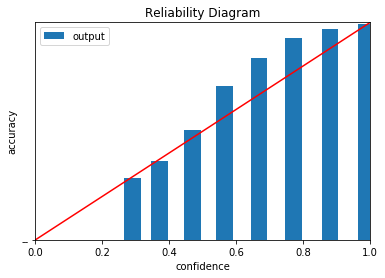

In [331]:
plt.figure()
plt.bar(x=x, height=y, width=0.05, label='output')
plt.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), 'r', '--')
plt.xlabel('confidence')
plt.ylabel('accuracy')
plt.title('Reliability Diagram')
plt.xlim(0, 1)
plt.ylim(0,1)
plt.legend()
plt.show()
plt.close()

# What Model Don't Know

In [341]:
test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('fashion-mnist-data/', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

Processing...
Done!


In [359]:
def predict(x, T):
    sampled_models = [guide(None, None) for _ in range(T)]
    yhats = [model(x).data for model in sampled_models]
    yhats = F.softmax(torch.stack(yhats, dim=1), dim=2)
    mean = torch.mean(yhats, 1).cpu().numpy()
    
    # uncertainty
    # yhats [batch * 10 * 10]
    p_hat = yhats.cpu().numpy()
    aleatoric = np.mean(p_hat*(1-p_hat), axis=1) # batch * 10
    epistemic = np.mean(p_hat**2, axis=1) - np.mean(p_hat, axis=1)**2 # batch * 10
    return np.argmax(mean, axis=1), mean, aleatoric, epistemic

def evaluate(T, loader, threshold=0.2):
    entropy = 0
    total = 0
    all_cnt = 0
    total_alea_thresh = 0
    total_epis_thresh = 0
    entropy = np.array([])
    for j, data in enumerate(loader):
        images, labels = data
        predicted, mean_prob, aleatoric, epistemic = predict(images.view(images.size(0), -1).cuda(), T=T)
        confidence = np.max(mean_prob, axis=1)
        idx = [idx for idx in range(confidence.shape[0]) if confidence[idx]>threshold]
        all_cnt += len(labels)
        total += len(idx)
        entropy = np.concatenate([entropy, confidence])
        # uncertainty for the best choice
        total_alea_thresh += np.choose(predicted, aleatoric.T).sum().item()
        total_epis_thresh += np.choose(predicted, epistemic.T).sum().item()
    entropy = -np.log(entropy)
    return all_cnt-total, total/all_cnt, total_alea_thresh/total, total_epis_thresh/total, entropy

In [372]:
skip, ratio, alea_mean, epis_mean, entropy = evaluate(10, test_loader, threshold=0.5)

In [373]:
print('number of sample skipped ', skip)
print('predict ratio ',ratio)
print('mean alea ', alea_mean)
print('mean epis ', epis_mean)

number of sample skipped  5411
predict ratio  0.4589
mean alea  0.007267275448067823
mean epis  0.45482352414300536


In [375]:
entropy_cnt = pd.Series(entropy).value_counts().sort_index()
cumulative = np.cumsum(entropy_cnt.values)

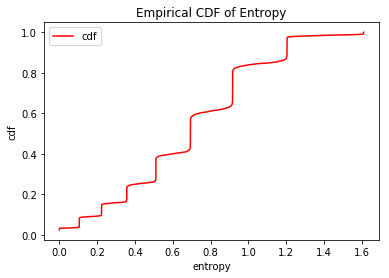

In [376]:
plt.figure()
plt.plot(entropy_cnt.index, cumulative/cumulative[-1], 'r', label='cdf')
plt.xlabel('entropy')
plt.ylabel('cdf')
plt.title('Empirical CDF of Entropy')
plt.legend()
plt.show()